In [1]:
%%bash
[[ ! -e /content/sample_data ]] && exit  ## run this cell only in colab
 
pip install optax -qqq
pip install networkx==2.5 -qqq
pip install netgraph
git clone https://github.com/ramithuh/differentiable-trees --quiet

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

if(os.path.exists('/content/sample_data')):
  sys.path.append('differentiable-trees/')

import jax.numpy as jnp
import jax.nn as nn
import jax
import optax
import functools

import pydot
import numpy as np
from helpers import *

from matplotlib import rc
rc('animation', html='jshtml')

In [3]:
key = jax.random.PRNGKey(42)

2022-11-03 14:51:18.294376: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/cudnn/8.5.0.96_cuda11-fasrc01/lib:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib:/usr/local/cuda/lib64::
2022-11-03 14:51:18.294430: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


## Sequences

In [4]:
# sequences (fixed)
n_leaves    = 3
n_ancestors = 2
n_all = n_leaves + n_ancestors

a = jnp.array([0,0,0,0]) 
b = jnp.array([1,0,0,1])
c = jnp.array([0,1,1,0])

# ancestral sequences (???)
d = jnp.array([1,1,1,1]) # ? 
e = jnp.array([0,0,0,0]) # ?

blank = jnp.array([0,0,0,0])

In [5]:
# similarity matrix (fixed)
sm = jnp.array([[0,1],
               [1,0]])

In [6]:
seqs = jnp.array([a,b,c,d,e],dtype=jnp.float32)

In [7]:
base_tree = jnp.zeros((n_all, n_all))

In [8]:
base_tree

DeviceArray([[0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.]], dtype=float32)

## Tree Topology (also parameterized)

### initialize parameters

In [9]:
optimizer = optax.adam(1)
# params = {'d': jnp.array([0,0,0.0,0.0]), 'e': jnp.array([0,0.0,0,0.0])}

params = {'d': jax.random.normal(key, (4,)), 'e': jax.random.normal(key, (4,)), 
          't': jax.random.normal(key, (n_all - 1,n_ancestors))}


opt_state = optimizer.init(params)

In [10]:
# t_q = jnp.argmax(t_softmax,axis = 1).T

In [11]:
base_tree.shape

(5, 5)

In [12]:
base_tree

DeviceArray([[0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.]], dtype=float32)

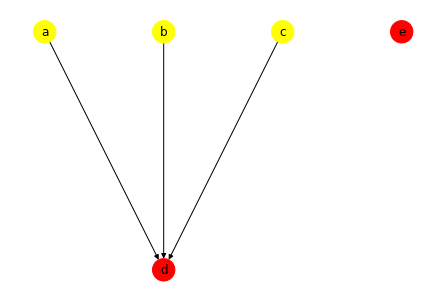

In [13]:
show_graph_with_labels(discretize_tree_topology(update_tree(params, base_tree), 5),n_leaves)

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


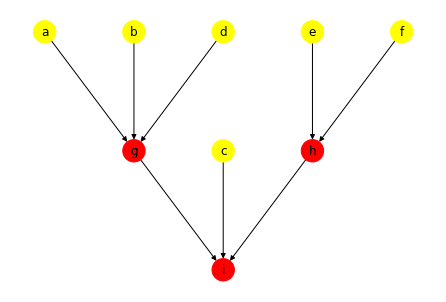

In [14]:
show_graph_with_labels(generate_t(9,6),6)

### Function to compute total distance

In [15]:
def compute_cost(sequences, tree, verbose = False, average = True):
    if(verbose==True):
        show_graph_with_labels(discretize_tree_topology(tree,5),n_leaves)
        
    selection = jnp.matmul(tree,sequences)
    # print(selection)
    
#     #method 1: (downside needs integers as we are indexing)
#     selection = selection.astype(int)
#     ans = sm[selection,sequences].sum()
    
    #method 2:
    if(average):
        ans = abs(selection - sequences).sum() ## works currently as sm is the basic config. need to think about extending
    else:
        ans = jnp.sum(abs(selection - sequences), axis = 1)
    
    return ans

In [16]:
seqs

DeviceArray([[0., 0., 0., 0.],
             [1., 0., 0., 1.],
             [0., 1., 1., 0.],
             [1., 1., 1., 1.],
             [0., 0., 0., 0.]], dtype=float32)

In [17]:
update_tree(params, base_tree)

DeviceArray([[0.        , 0.        , 0.        , 0.55906475, 0.4409352 ],
             [0.        , 0.        , 0.        , 0.51879424, 0.4812058 ],
             [0.        , 0.        , 0.        , 0.78316945, 0.21683054],
             [0.        , 0.        , 0.        , 0.7270455 , 0.2729545 ],
             [0.        , 0.        , 0.        , 0.        , 1.        ]],            dtype=float32)

DeviceArray(7.328077, dtype=float32)

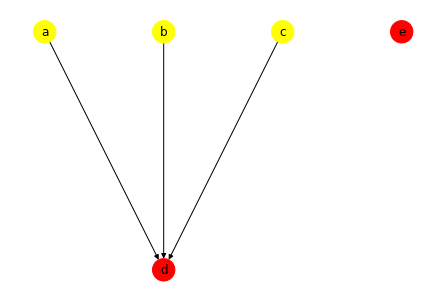

In [18]:
compute_cost(seqs,update_tree(params, base_tree),1)

In [19]:
params

{'d': DeviceArray([ 0.18693547,  1.0653335 , -1.5593132 , -1.5352962 ], dtype=float32),
 'e': DeviceArray([ 0.18693547,  1.0653335 , -1.5593132 , -1.5352962 ], dtype=float32),
 't': DeviceArray([[ 0.48962495,  0.25225756],
              [-0.6273903 , -0.7026026 ],
              [ 0.71573365, -0.5684993 ],
              [-1.746183  , -2.725867  ]], dtype=float32)}

In [20]:
def regularize_graph(t_, s):
    tree_force_loss = (s*abs(t_[:-1,-2].sum()-2))**2 + (s*abs(t_[:-1,-1].sum()-2))**2
    
    loop_loss = jnp.multiply(jnp.identity(n_all-1), t_[:-1,:-1]).sum()*100  ## penalize self connections
    
    return tree_force_loss + loop_loss

In [21]:
def compute_loss(params, seqs, base_tree):
    seqs_ = combine_to_seq(params, seqs)
    t_    = update_tree(params, base_tree)

    loss  = compute_cost(seqs_,t_) + regularize_graph(t_,10)
    
    return loss

In [22]:
base_tree

DeviceArray([[0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.]], dtype=float32)

In [23]:
compute_loss(params, seqs, base_tree)

DeviceArray(147.51198, dtype=float32)

In [24]:
trees = []

for _ in range(500):
    grads = jax.grad(compute_loss)(params, seqs, base_tree)
    
    
    t_= update_tree(params, base_tree)
    t__ = discretize_tree_topology(t_,n_all)
    t__ = t__.at[-1,-1].set(0)
    
    trees.append(t__)
    
    if(_%100==0):
        # temp  = combine_to_seq(params, seqs)
        
        print("{:.5f}".format(compute_loss(params, seqs, base_tree)),end = " seq = {")
        print(t_[:,-2],",",t_[:,-1],end="}\n")
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


147.51198 seq = {[0.55906475 0.51879424 0.78316945 0.7270455  0.        ] , [0.4409352  0.4812058  0.21683054 0.2729545  1.        ]}
4.02793 seq = {[9.8996115e-01 1.4239745e-03 9.9999094e-01 1.3394264e-04 0.0000000e+00] , [1.0038844e-02 9.9857605e-01 9.0817921e-06 9.9986601e-01 1.0000000e+00]}
4.01577 seq = {[9.9346429e-01 1.5468348e-03 9.9999094e-01 1.0906152e-04 0.0000000e+00] , [6.5356907e-03 9.9845314e-01 9.0711019e-06 9.9989092e-01 1.0000000e+00]}
4.01104 seq = {[9.9491054e-01 1.6689324e-03 9.9999094e-01 8.7365588e-05 0.0000000e+00] , [5.0895126e-03 9.9833113e-01 9.0676422e-06 9.9991262e-01 1.0000000e+00]}
4.00828 seq = {[9.9571663e-01 1.7898814e-03 9.9999094e-01 7.0292270e-05 0.0000000e+00] , [4.2833039e-03 9.9821007e-01 9.0650310e-06 9.9992967e-01 1.0000000e+00]}


In [25]:
adjacency_matrix2 = jnp.array(trees)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/n/home12/ramith/.conda/envs/jax_python38/lib/python3.8/site-packages/netgraph/_utils.py:395: RuntimeWarning: invalid value encountered in divide
  unit_vector = vector / np.linalg.norm(vector)


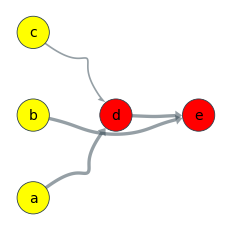

In [28]:
animate_tree(adjacency_matrix2, n_leaves, n_ancestors)

In [ ]:
animation

In [ ]:
cost_

In [ ]:
edge_names

In [ ]:
plt.imshow(adjacency_matrix2[300])
plt.colorbar()

In [ ]:
plt.imshow(adjacency_matrix2[-1])
plt.colorbar()

In [ ]:
label_names = {}
    
    for i in range(0,adjacency_matrix.shape[0]):
        label_names[i] = chr(97+i)

## Retrieving the new sequences array

In [ ]:
t_new = discretize_tree_topology(update_tree(params, base_tree), n_leaves + n_ancestors)

In [ ]:
discretized = jnp.round(combine_to_seq(params, seqs))

In [ ]:
discretized

### New cost

In [ ]:
t_new

In [ ]:
compute_cost(discretized, t_new, 1)

In [ ]:
t_new

### Old cost

In [ ]:
compute_cost(seqs, base_tree) ##when d & e were all zeros

### test arbitrary sequence for d & e

In [ ]:
test = jnp.array([[0, 0., 0., 0.],
                 [1., 0., 0., 1.],
                 [0., 1., 1., 0.],
                 [0., 0., 0., 0.],
                 [0., 0., 0., 0.]])

In [ ]:
compute_cost(test, t_new)